In [ ]:
## Notebook env: cellprofiler (R kernel)

In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(stringr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggridges))
suppressMessages(library(ggpubr))

In [2]:
## Extract metadata
## No pertinent data in Image besides total object counts per image -- not helpful for heterogeneity
Image = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/Image.csv')
metadata = data.frame(ImageNumber = 1:nrow(Image), sample = Image$Metadata_Sample, site = Image$Metadata_Site, replicate = Image$Metadata_Replicate)
conditions = c('RNF8A-CRISPRi', 'MIS18A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi', 'HMGA1-CRISPRi', 'RNF8A-CRISPRa', 'MIS18A-CRISPRa', 'NTCi', 'NTCa')
metadata$sample_name = plyr::mapvalues(metadata$sample, from = 1:9, to = conditions)
metadata = metadata %>% select('ImageNumber', 'sample', 'sample_name', 'site', 'replicate') %>% as.data.frame()
head(metadata)

,ImageNumber,sample,sample_name,site,replicate
,<int>,<int>,<chr>,<int>,<chr>
1,1,1,RNF8A-CRISPRi,1,A
2,2,1,RNF8A-CRISPRi,2,A
3,3,1,RNF8A-CRISPRi,3,A
4,4,1,RNF8A-CRISPRi,4,A
5,5,1,RNF8A-CRISPRi,5,A
6,6,1,RNF8A-CRISPRi,6,A


In [3]:
## load in data ##
cellbody = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/cellbody.csv')
cell_borders_secondary_via_nuclei = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/cell_borders_secondary_via_nuclei.csv')
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary.csv')
ergolgi = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/ERGolgi.csv')
mitochondria = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/Mitochondria.csv')
nuclei = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/cell_painting/10x_v1/Nuclei.csv')

## for cell_borders_secondary_via_nuclei can use the cellbody channel for intensity measurements of cellbody (this dataframe is an alternative measurement of cellbody made via IdentifySecondaryObjects function in cellprofiler which uses the nuclei as a containing object to call the cellbody borders)
## for cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary can only do size and shape measurements -- can't do intensity since cytoplasm never explicitly stained (this dataframe is a measurement of the cytoplasm made via IdentifyTertiaryObjects function in cellprofiler which subtracts the nuclei from the cell_borders_secondary_via_nuclei object)

## get rid of all objects of the wrong channel in each dataframe
## also getting rid of children count column(s) for nuclei df, and children_nuclei_count for cellbody df -- decide later if worth analyzing
cellbody = cellbody %>% select(-contains('ERGolgi'), -contains('Mitochondria'), -contains('DNA'), -contains('Location'), -contains('BoundingBox'), -contains('Center'), -contains('Children_Nuclei_Count'))
cell_borders_secondary_via_nuclei = cell_borders_secondary_via_nuclei %>% select(-contains('ERGolgi'), -contains('Mitochondria'), -contains('DNA'), -contains('Location'), -contains('BoundingBox'), -contains('Center'))
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary = cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary %>% select(-contains('Intensity'), -contains('Location'))
ergolgi = ergolgi %>% select(-contains('cellbody'), -contains('Mitochondria'), -contains('DNA'), -contains('Location'), -contains('BoundingBox'), -contains('Center'))
mitochondria = mitochondria %>% select(-contains('cellbody'), -contains('ERGolgi'), -contains('DNA'), -contains('Location'), -contains('BoundingBox'), -contains('Center'))
nuclei = nuclei %>% select(-contains('cellbody'), -contains('ERGolgi'), -contains('Mitochondria'), -contains('Location'), -contains('BoundingBox'), -contains('Center'),  -contains('Children'))

cellbody = cellbody %>% rename_with(~str_remove(., '.cellbody'))
cell_borders_secondary_via_nuclei = cell_borders_secondary_via_nuclei %>% rename_with(~str_remove(., '.cellbody'))
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary = cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary %>% rename_with(~str_remove(., '.cellbody'))
ergolgi = ergolgi %>% rename_with(~str_remove(., '.ERGolgi'))
mitochondria = mitochondria %>% rename_with(~str_remove(., '.Mitochondria'))
nuclei = nuclei %>% rename_with(~str_remove(., '.DNA'))

cellbody$channel = cellbody$object = 'cellbody'
cell_borders_secondary_via_nuclei$channel = 'cellbody'
cell_borders_secondary_via_nuclei$object = 'cell_borders_secondary_via_nuclei'
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary$channel = 'cellbody'
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary$object = 'cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary'
ergolgi$channel = ergolgi$object = 'ergolgi'
mitochondria$channel = mitochondria$object = 'mitochondria'
nuclei$channel = nuclei$object = 'nuclei'


## merge metadata
data = list(cellbody, cell_borders_secondary_via_nuclei, cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary, ergolgi, mitochondria, nuclei)
names(data) = c('cellbody', 'cell_borders_secondary_via_nuclei', 'cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary', 'ergolgi', 'mitochondria', 'nuclei')
data = lapply(data, left_join, metadata, by = 'ImageNumber')

## remove images with aberrant object calls
imgs_to_remove = data[['nuclei']] %>% filter((sample_name == 'NTCa' & replicate == 'A' & site == 7) | (sample_name == 'NTCi' & replicate == 'B' & site == 9)) %>% pull(ImageNumber) %>% unique()
nuclei = nuclei %>% filter(!(ImageNumber %in% imgs_to_remove))
cellbody = cellbody %>% filter(!(ImageNumber %in% imgs_to_remove))
cell_borders_secondary_via_nuclei = cell_borders_secondary_via_nuclei %>% filter(!(ImageNumber %in% imgs_to_remove))
cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary = cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary %>% filter(!(ImageNumber %in% imgs_to_remove))
ergolgi = ergolgi %>% filter(!(ImageNumber %in% imgs_to_remove))
mitochondria = mitochondria %>% filter(!(ImageNumber %in% imgs_to_remove))

data[['cellbody']] = data[['cellbody']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['cell_borders_secondary_via_nuclei']] = data[['cell_borders_secondary_via_nuclei']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary']] = data[['cytoplasm_borders_tertiary_via_nuclei_primary_cell_borders_secondary']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['ergolgi']] = data[['ergolgi']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['mitochondria']] = data[['mitochondria']] %>% filter(!(ImageNumber %in% imgs_to_remove))
data[['nuclei']] = data[['nuclei']] %>% filter(!(ImageNumber %in% imgs_to_remove))

In [4]:
## pick middle three images to sample equally from across conditions
data = lapply(data, function(x) x %>% filter(replicate == 'B' & site == 4 | site == 5 | site == 6))

In [5]:
### PCA analysis functions ###

#find euclidean mean vector for cells per each drug treatment
centroid_appender <- function(x){
  control_pct = rbind(colMeans(x[[1]]), x[[1]])
  expt_pct = rbind(colMeans(x[[2]]), x[[2]])
  return(list(control_pct, expt_pct))
}

weighted_distance_calculator = function(x, weights) {
  control_dist = apply(x[[1]][-1,], 1, function(z, centroid) {sqrt(sum(weights*(z - centroid)^2))}, x[[1]][1,])
  expt_dist = apply(x[[2]][-1,], 1, function(z, centroid) {sqrt(sum(weights*(z - centroid)^2))}, x[[2]][1,])
  return(list(control_dist, expt_dist))
}

mean_distance_calculator <- function(x){
  return(c(mean(as.numeric(x[[1]])), mean(as.numeric(x[[2]]))))
}

median_distance_calculator <- function(x){
  return(c(median(as.numeric(x[[1]])), median(as.numeric(x[[2]]))))
}

mad_caluclator <- function(x){
  return(c(mad(as.numeric(x[[1]])), mad(as.numeric(x[[2]]))))
}

cv_calculator <- function(x){
  return(c(sd(as.numeric(x[[1]]))/mean(as.numeric(x[[1]])), sd(as.numeric(x[[2]]))/mean(as.numeric(x[[2]]))))
}

stdev_calculator <- function(x){
  return(c(sd(as.numeric(x[[1]])), sd(as.numeric(x[[2]]))))
}

In [6]:
## pick middle three images to sample equally from across conditions
#data = lapply(data, function(x) x %>% filter(replicate == 'B' & site == 4 | site == 5 | site == 6))

seeds = 1:100
sums = rep(0, length(seeds))
list_of_objs_distances = list()
list_of_objs_distances_mean = list()
for (i in 1:length(seeds)){
    ## sample 200 objects from each condition
primary_objects_data = bind_rows(data[['cellbody']], data[['mitochondria']], data[['ergolgi']], data[['nuclei']])
primary_objects_data$sample_name = factor(primary_objects_data$sample_name, levels = rev(conditions))

seed = seeds[i]  ## seed 3 good all except RNF8i
set.seed(seed)
primary_objects_data = suppressMessages(suppressWarnings(primary_objects_data %>% group_by(channel, sample_name) %>% sample_n(200)))


## make heatmap of CV values of these features across conditions
# area and intensity
select_features_primary_objects_data_CV = suppressMessages(suppressWarnings(primary_objects_data %>% select('AreaShape_Area', 'Intensity_IntegratedIntensity', 'Intensity_MeanIntensity', 'Intensity_MedianIntensity', 'Intensity_MaxIntensity', 'sample_name', 'channel') %>% group_by(sample_name, channel) %>% summarize(AreaShape_Area_CV = signif(sd(AreaShape_Area)/mean(AreaShape_Area), 3), Intensity_IntegratedIntensity_CV = signif(sd(Intensity_IntegratedIntensity)/mean(Intensity_IntegratedIntensity), 3), Intensity_MeanIntensity_CV = signif(sd(Intensity_MeanIntensity)/mean(Intensity_MeanIntensity), 3), Intensity_MedianIntensity_CV = signif(sd(Intensity_MedianIntensity)/mean(Intensity_MedianIntensity), 3), Intensity_MaxIntensity_CV = signif(sd(Intensity_MaxIntensity)/mean(Intensity_MaxIntensity), 3)) %>% as.data.frame()))
rownames(select_features_primary_objects_data_CV) = paste(select_features_primary_objects_data_CV$sample_name, select_features_primary_objects_data_CV$channel, sep = '_')
select_features_primary_objects_data_CV_mtx = select_features_primary_objects_data_CV %>% select(-sample_name, -channel) %>% as.matrix()
#head(select_features_primary_objects_data_CV_mtx)

# shape
CV_func = function(x){sd(x, na.rm = TRUE)/mean(x, na.rm = TRUE)}
## convert all infinities to NA
primary_objects_data = suppressMessages(primary_objects_data %>% mutate_all(~replace(., is.infinite(.), NA)) %>% drop_na()) ## remove any object with infinite value for any feature
shape_features_primary_objects_data_CV = suppressMessages(suppressWarnings(primary_objects_data %>% select('AreaShape_Compactness', 'AreaShape_ConvexArea', 'AreaShape_Eccentricity', 'AreaShape_EquivalentDiameter', 'AreaShape_EulerNumber', 'AreaShape_Extent', 'AreaShape_FormFactor', 'AreaShape_MajorAxisLength', 'AreaShape_MinorAxisLength',
'AreaShape_MaxFeretDiameter', 'AreaShape_MaximumRadius', 'AreaShape_MeanRadius', 'AreaShape_MedianRadius', 'AreaShape_MinFeretDiameter', 'AreaShape_Orientation', 
'AreaShape_Perimeter', 'AreaShape_Solidity', 
'AreaShape_Zernike_0_0', 'AreaShape_Zernike_1_1', 'AreaShape_Zernike_2_0', 'AreaShape_Zernike_2_2', 'AreaShape_Zernike_3_1', 'AreaShape_Zernike_3_3', 'AreaShape_Zernike_4_0', 'AreaShape_Zernike_4_2', 'AreaShape_Zernike_4_4', 'AreaShape_Zernike_5_1', 'AreaShape_Zernike_5_3', 'AreaShape_Zernike_5_5', 'AreaShape_Zernike_6_0', 'AreaShape_Zernike_6_2', 'AreaShape_Zernike_6_4', 'AreaShape_Zernike_6_6', 'AreaShape_Zernike_7_1', 'AreaShape_Zernike_7_3', 'AreaShape_Zernike_7_5', 'AreaShape_Zernike_7_7', 'AreaShape_Zernike_8_0', 'AreaShape_Zernike_8_2', 'AreaShape_Zernike_8_4', 'AreaShape_Zernike_8_6', 'AreaShape_Zernike_8_8', 'AreaShape_Zernike_9_1', 'AreaShape_Zernike_9_3', 'AreaShape_Zernike_9_5', 'AreaShape_Zernike_9_7', 'AreaShape_Zernike_9_9',
'Intensity_MassDisplacement', 'sample_name', 'channel') %>% group_by(sample_name, channel) %>% summarize_all(CV_func) %>% as.data.frame()))
rownames(shape_features_primary_objects_data_CV) = paste(shape_features_primary_objects_data_CV$sample_name, shape_features_primary_objects_data_CV$channel, sep = '_')
shape_features_primary_objects_data_CV_mtx = shape_features_primary_objects_data_CV %>% select(-sample_name, -channel) %>% as.matrix()
#head(shape_features_primary_objects_data_CV_mtx)

## run PCA on CV values of these shape features or all features and show PC1 vs PC2 plot
## run PCA on Zernike features (mean) alone to show they are distinct across conditions (ie shape is distinct across conditions)
## not using 'AreaShape_Orientation' as it has extremely high variance and is not informative for heterogeneity

primary_objects_data_PCA = primary_objects_data %>% select('AreaShape_Area', 'Intensity_IntegratedIntensity', 'Intensity_MeanIntensity', 'Intensity_MedianIntensity', 'Intensity_MaxIntensity', 'AreaShape_Compactness', 'AreaShape_ConvexArea', 'AreaShape_Eccentricity', 'AreaShape_EquivalentDiameter', 'AreaShape_EulerNumber', 'AreaShape_Extent', 'AreaShape_FormFactor', 'AreaShape_MajorAxisLength', 'AreaShape_MinorAxisLength',
'AreaShape_MaxFeretDiameter', 'AreaShape_MaximumRadius', 'AreaShape_MeanRadius', 'AreaShape_MedianRadius', 'AreaShape_MinFeretDiameter', 
'AreaShape_Perimeter', 'AreaShape_Solidity', 'AreaShape_Zernike_0_0', 'AreaShape_Zernike_1_1', 'AreaShape_Zernike_2_0', 'AreaShape_Zernike_2_2', 'AreaShape_Zernike_3_1', 'AreaShape_Zernike_3_3', 'AreaShape_Zernike_4_0', 'AreaShape_Zernike_4_2', 'AreaShape_Zernike_4_4', 'AreaShape_Zernike_5_1', 'AreaShape_Zernike_5_3', 'AreaShape_Zernike_5_5', 'AreaShape_Zernike_6_0', 'AreaShape_Zernike_6_2', 'AreaShape_Zernike_6_4', 'AreaShape_Zernike_6_6', 'AreaShape_Zernike_7_1', 'AreaShape_Zernike_7_3', 'AreaShape_Zernike_7_5', 'AreaShape_Zernike_7_7', 'AreaShape_Zernike_8_0', 'AreaShape_Zernike_8_2', 'AreaShape_Zernike_8_4', 'AreaShape_Zernike_8_6', 'AreaShape_Zernike_8_8', 'AreaShape_Zernike_9_1', 'AreaShape_Zernike_9_3', 'AreaShape_Zernike_9_5', 'AreaShape_Zernike_9_7', 'AreaShape_Zernike_9_9',
'Intensity_MassDisplacement', 'sample_name', 'channel', 'ImageNumber', 'replicate') %>% as.data.frame() 

## at this point only working with replicate B
primary_objects_data_PCA = primary_objects_data_PCA %>% filter(replicate == 'B') %>% select(-replicate) %>% as.data.frame()
rownames(primary_objects_data_PCA) = paste(primary_objects_data_PCA$sample_name, rownames(primary_objects_data_PCA), sep = '_')
primary_objects_data_PCA = primary_objects_data_PCA %>% select(-sample_name) %>% as.data.frame()

primary_objects_data_PCA_cellbody = primary_objects_data_PCA %>% filter(channel == 'mitochondria') %>% select(-channel) %>% as.matrix()
primary_objects_data_PCA_cellbody_row_id = paste(sapply(stringr::str_split(rownames(primary_objects_data_PCA_cellbody), '_'), '[[', 1), primary_objects_data_PCA_cellbody %>% as.data.frame() %>% pull(ImageNumber), sep = '_')


### PCA analysis on all features by experimental condition -- cellbody channel ###
## drop any column that has sd = 0
if(sum(apply(primary_objects_data_PCA_cellbody, 2, sd) == 0) > 0){
    primary_objects_data_PCA_cellbody = primary_objects_data_PCA_cellbody[,-as.numeric(which(apply(primary_objects_data_PCA_cellbody, 2, sd) == 0))]
}
pca1 = prcomp(primary_objects_data_PCA_cellbody, scale. = TRUE)
PCA_coordinates = pca1$x
PCA_coordinates_final = PCA_coordinates[, 1:50]

# PCA_coordinates_final -> PCA_coordinates_final_q25_q75_top2000DEGs
eigs <- pca1$sdev^2
eigen_values = eigs
explained_variance = eigs/sum(eigs)
explained_variance = explained_variance[1:50]

names = sapply(stringr::str_split(rownames(PCA_coordinates_final), '_'), '[[', 1)
PCA_coordinates_final_annoated = as.data.frame(cbind(names, PCA_coordinates_final))
list_of_PCA_coordinates_final = split(PCA_coordinates_final_annoated, f = PCA_coordinates_final_annoated$names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, select, -names)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, as.matrix)
names(list_of_PCA_coordinates_final) = as.character(sapply(list_of_PCA_coordinates_final, function(x) sapply(stringr::str_split(rownames(x), '_'), '[[', 1) %>% unique()))
#list_of_PCA_coordinates_final_rownames = lapply(list_of_PCA_coordinates_final, rownames)
list_of_PCA_coordinates_final = lapply(list_of_PCA_coordinates_final, apply, 2, as.numeric)

HMGA1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['HMGA1-CRISPRi']]))
MIS18A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['MIS18A-CRISPRa']]))
MIS18A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['MIS18A-CRISPRi']]))
RNF8A_CRISPRa_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCa']], list_of_PCA_coordinates_final[['RNF8A-CRISPRa']]))
RNF8A_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RNF8A-CRISPRi']]))
RUVBL1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['RUVBL1-CRISPRi']]))
VRK1_CRISPRi_with_centroid = centroid_appender(list(list_of_PCA_coordinates_final[['NTCi']], list_of_PCA_coordinates_final[['VRK1-CRISPRi']]))

list_objs = list(HMGA1_CRISPRi_with_centroid, MIS18A_CRISPRa_with_centroid, MIS18A_CRISPRi_with_centroid, RNF8A_CRISPRa_with_centroid, RNF8A_CRISPRi_with_centroid, RUVBL1_CRISPRi_with_centroid, VRK1_CRISPRi_with_centroid)
names(list_objs) = c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi')
list_of_objs_distances[[i]] = list(list_objs, explained_variance)
objs_distances_mean = lapply(list_objs, function(x) mean_distance_calculator(weighted_distance_calculator(x, explained_variance)))
objs_distances_mean = as.data.frame(t(as.data.frame(objs_distances_mean)))
colnames(objs_distances_mean) = c('control', 'expt')
rownames(objs_distances_mean) = c('HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi')
objs_distances_mean = tibble::rownames_to_column(objs_distances_mean, 'sample')
objs_distances_mean$ratio = objs_distances_mean$expt/objs_distances_mean$control
objs_distances_mean$CRISPRi_binary = ifelse(endsWith(objs_distances_mean$sample, 'CRISPRi') & grepl('MIS18A|RNF8', objs_distances_mean$sample) & objs_distances_mean$ratio < 1, 1, 0)
objs_distances_mean$CRISPRa_binary = ifelse(endsWith(objs_distances_mean$sample, 'CRISPRa') & grepl('MIS18A|RNF8', objs_distances_mean$sample) & objs_distances_mean$ratio > 1, 1, 0)
objs_distances_mean$binary = objs_distances_mean$CRISPRi_binary + objs_distances_mean$CRISPRa_binary
list_of_objs_distances_mean[[i]] = objs_distances_mean
sums[i] = sum(objs_distances_mean$binary)
}

In [7]:
sums
list_of_objs_distances_mean[which(sums == 3)]

[1] 1 3 1 3 1 1 2 2 3 2 0 1 2 3 3 1 3 2 2 0 2 3 2 1 3 2 2 2 3 2 2 3 2 2 2 2 2
 [38] 2 2 2 1 2 4 2 3 2 2 2 2 1 3 1 2 3 0 2 1 3 1 2 2 1 3 1 0 2 2 2 2 2 1 1 1 3
 [75] 2 1 2 1 2 2 2 2 2 3 2 2 2 2 3 2 1 1 1 2 2 3 3 2 2 3

sample,control,expt,ratio,CRISPRi_binary,CRISPRa_binary,binary
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HMGA1-CRISPRi,2.024575,1.873834,0.9255444,0,0,0
MIS18A-CRISPRa,1.859313,1.892448,1.0178211,0,1,1
MIS18A-CRISPRi,2.024575,1.875371,0.9263034,1,0,1
RNF8A-CRISPRa,1.859313,1.939072,1.0428975,0,1,1
RNF8A-CRISPRi,2.024575,2.010487,0.9930416,1,0,1
RUVBL1-CRISPRi,2.024575,2.038460,1.0068582,0,0,0
VRK1-CRISPRi,2.024575,1.854390,0.9159403,0,0,0


In [10]:
list_of_objs_distances_mean[c(14, 22)]


sample,control,expt,ratio,CRISPRi_binary,CRISPRa_binary,binary
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HMGA1-CRISPRi,1.879835,1.849791,0.9840178,0,0,0
MIS18A-CRISPRa,1.701177,1.721461,1.0119236,0,1,1
MIS18A-CRISPRi,1.879835,1.813571,0.9647503,1,0,1
RNF8A-CRISPRa,1.701177,1.929030,1.1339386,0,1,1
RNF8A-CRISPRi,1.879835,2.086470,1.1099217,0,0,0
RUVBL1-CRISPRi,1.879835,2.033536,1.0817630,0,0,0
VRK1-CRISPRi,1.879835,1.894591,1.0078494,0,0,0
sample,control,expt,ratio,CRISPRi_binary,CRISPRa_binary,binary
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [9]:
which(sums == 3)

[1]   2   4   9  14  15  17  22  25  29  32  45  51  54  58  63  74  84  89  96
[20]  97 100

In [11]:
which(sums == max(sums))

[1] 43

In [10]:
## 42##, 49, 84 seeds good, 124, 187## good

In [16]:
dists = list()
distance_obj = list_of_objs_distances[[42]]
for (i in 1:length(distance_obj[[1]])){
    #control = weighted_distance_calculator(distance_obj[[1]][[i]], distance_obj[[2]])[[1]]
    expt = weighted_distance_calculator(distance_obj[[1]][[i]], distance_obj[[2]])[[2]]
    dists[[i]] = data.frame(sample_name = names(distance_obj[[1]])[i], distances = expt)
}

control = weighted_distance_calculator(distance_obj[[1]][[which(endsWith(names(distance_obj[[1]]), 'CRISPRi'))[1]]], distance_obj[[2]])[[1]]
dists[[i + 1]] = data.frame(sample_name = 'NTCi', distances = control)
control = weighted_distance_calculator(distance_obj[[1]][[which(endsWith(names(distance_obj[[1]]), 'CRISPRa'))[1]]], distance_obj[[2]])[[1]]
dists[[i + 2]] = data.frame(sample_name = 'NTCa', distances = control)

dists = bind_rows(dists)


In [17]:
dists$sample_name = factor(dists$sample_name, levels = c('NTCi', 'NTCa', 'HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi'))

samples = dists %>% pull(sample_name) %>% unique() %>% sort()
my_comparisons = list(c(samples[1], samples[3]), c(samples[1], samples[5]), c(samples[1], samples[7]), c(samples[1], samples[8]), c(samples[1], samples[9]))
my_comparisons = lapply(my_comparisons, as.character)
upper_lim = max(dists %>% pull(distances))*1.05

plt1a = dists %>% filter(endsWith(as.character(sample_name), 'i')) %>% ggplot(aes(x=sample_name, y=distances, fill=sample_name)) + theme_pubr() + xlab('') + coord_cartesian(ylim = c(0,6)) + stat_compare_means(method = "t.test", comparisons = my_comparisons, label.y = 3.8, step.increase = 0.03, method.args = list(alternative = "greater")) +
  geom_boxplot(show.legend = FALSE, outlier.shape = NA)+ theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

In [18]:
dists$sample_name = factor(dists$sample_name, levels = c('NTCi', 'NTCa', 'HMGA1-CRISPRi', 'MIS18A-CRISPRa', 'MIS18A-CRISPRi', 'RNF8A-CRISPRa', 'RNF8A-CRISPRi', 'RUVBL1-CRISPRi', 'VRK1-CRISPRi'))

samples = dists %>% pull(sample_name) %>% unique() %>% sort()
my_comparisons = list(c(samples[2], samples[4]), c(samples[2], samples[6]))
my_comparisons = lapply(my_comparisons, as.character)
upper_lim = max(dists %>% pull(distances))*1.05

plt1b = dists %>% filter(endsWith(as.character(sample_name), 'a')) %>% ggplot(aes(x=sample_name, y=distances, fill=sample_name)) + theme_pubr() + xlab('') + coord_cartesian(ylim = c(0, 4.5)) + stat_compare_means(method = "t.test", comparisons = my_comparisons, label.y = 3.8, step.increase = 0.05, method.args = list(alternative = "less")) +
  geom_boxplot(show.legend = FALSE, outlier.shape = NA)+ theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

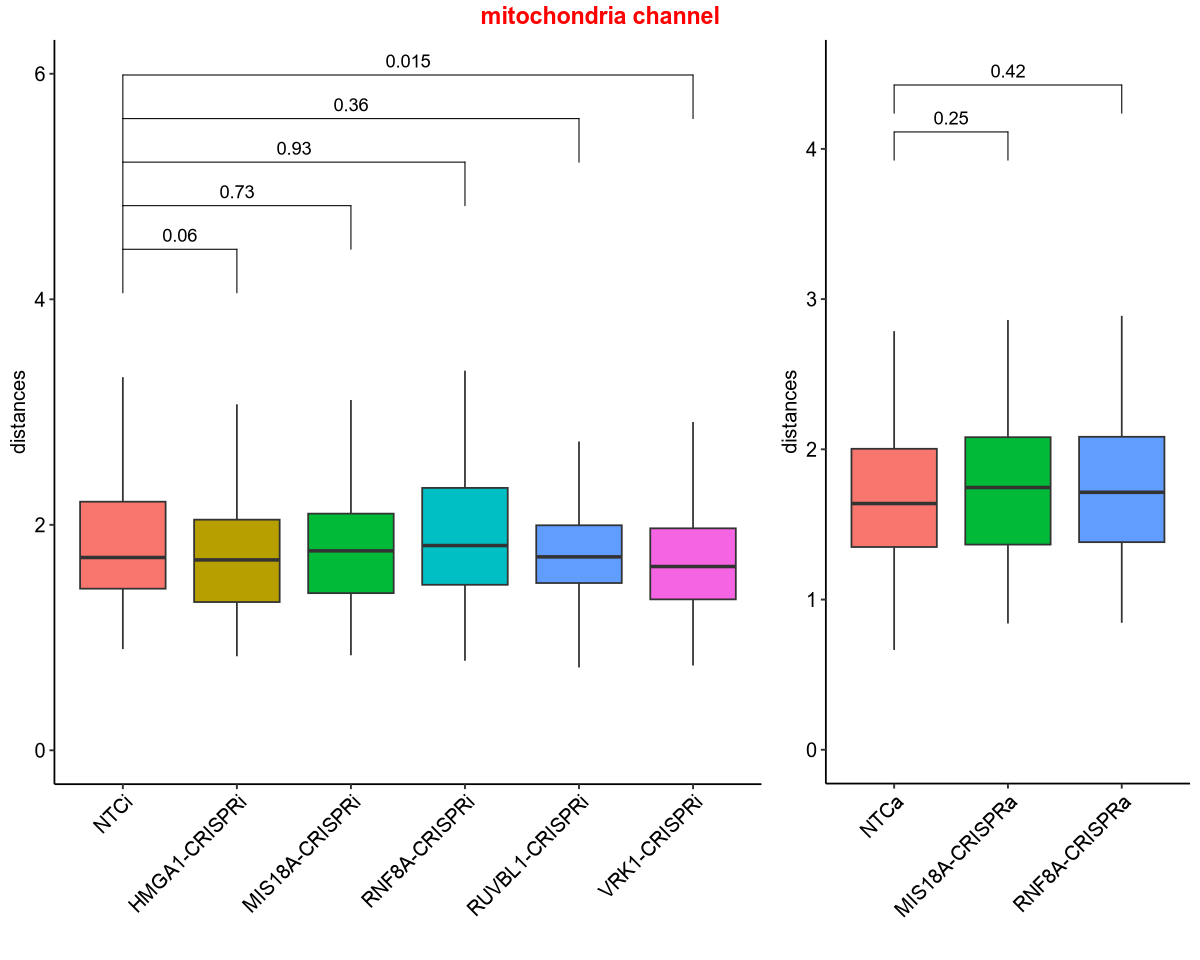

In [19]:
options(repr.plot.width=10, repr.plot.height=8)
annotate_figure(ggarrange(plt1a, plt1b, ncol = 2, widths = c(1.8, 1)), top = text_grob("mitochondria channel", color = "red", face = "bold", size = 14))

In [ ]:
## find Ci images with low CV values for all features

## find Ca images with high CV values for all features
## establish images with mean NTCi and NTCa values for all features
## images vs features